Loading training data...
Extracting time features...
Original dataset - Fraud cases: 7506, Non-fraud cases: 1289169
Training dataset - Fraud cases: 7506, Non-fraud cases: 38000
Loading test data...
Preprocessing data...
Training SVM model on GPU...
Training Random Forest model on GPU...


/home/hessel/miniconda3/envs/gpu-svc/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/hessel/miniconda3/envs/gpu-svc/lib/python3.9/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Evaluating models...

SVM Results:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.29      0.30      0.29      2145

    accuracy                           0.99    555719
   macro avg       0.64      0.65      0.65    555719
weighted avg       0.99      0.99      0.99    555719



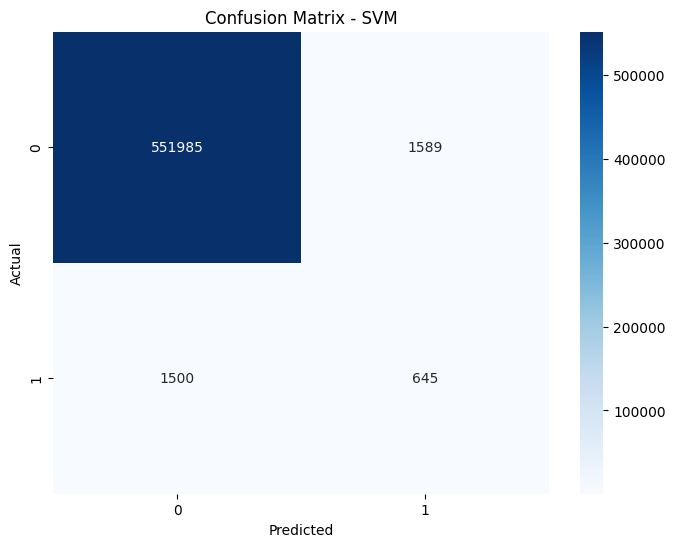


Random Forest Results:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.44      0.79      0.56      2145

    accuracy                           1.00    555719
   macro avg       0.72      0.89      0.78    555719
weighted avg       1.00      1.00      1.00    555719



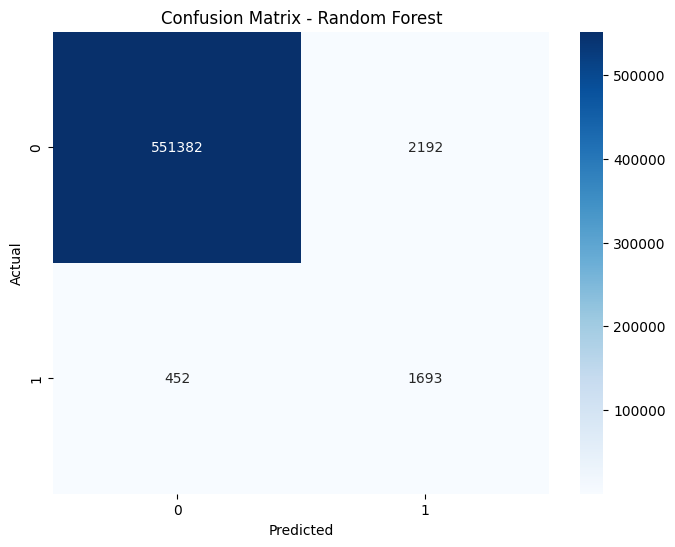

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from cuml.svm import SVC
from cuml.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from datetime import datetime
import sys
sys.path.append("../")

from tools.EnergyMeter.energy_meter import EnergyMeter

# RobustLabelEncoder and extract_time_features remain the same
class RobustLabelEncoder:
    def __init__(self):
        self.mapping = {}
        self.counter = 0
        
    def fit(self, data):
        unique_values = pd.Series(data).unique()
        for value in unique_values:
            self.mapping[value] = self.counter
            self.counter += 1
        return self
    
    def transform(self, data):
        return pd.Series(data).map(lambda x: self.mapping.get(x, self.counter))
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

def extract_time_features(df):
    """Extract features from transaction timestamp and DOB"""
    df['trans_datetime'] = pd.to_datetime(df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')
    
    df['trans_hour'] = df['trans_datetime'].dt.hour.astype(float)
    df['trans_day'] = df['trans_datetime'].dt.day.astype(float)
    df['trans_month'] = df['trans_datetime'].dt.month.astype(float)
    df['trans_day_of_week'] = df['trans_datetime'].dt.dayofweek.astype(float)
    df['is_weekend'] = df['trans_datetime'].dt.dayofweek.isin([5, 6]).astype(float)
    
    df['dob_datetime'] = pd.to_datetime(df['dob'], format='%Y-%m-%d')
    df['age'] = (df['trans_datetime'] - df['dob_datetime']).dt.days / 365.25
    df['age'] = df['age'].astype(float)
    df['age_decade'] = (df['age'] // 10 * 10).astype(float)
    
    df = df.drop(['trans_datetime', 'dob_datetime', 'trans_date_trans_time', 'dob'], axis=1)
    
    return df

def train_fraud_detection(train_path, test_path=None, fraud_ratio=0.3, sample_size=100000):
    """Train fraud detection models with energy metering"""
    # Initialize energy meter
    meter = EnergyMeter(
        disk_avg_speed=1600*1e6,
        disk_active_power=6,
        disk_idle_power=1.42,
        label="Power usage LLM query", 
        include_idle=False
    )
    
    energy_results = {}

    # Start measuring energy consumption
    meter.begin()
    
    print("Loading training data...")
    train_data = pd.read_csv(train_path)
    
    drop_cols = [
        'Unnamed: 0', 'cc_num', 'first', 'last', 'street', 'city', 
        'state', 'zip', 'trans_num'
    ]
    train_data = train_data.drop(columns=[col for col in drop_cols if col in train_data.columns])
    
    print("Extracting time features...")
    train_data = extract_time_features(train_data)
    
    fraud_data = train_data[train_data['is_fraud'] == 1]
    non_fraud_data = train_data[train_data['is_fraud'] == 0]
    
    print(f"Original dataset - Fraud cases: {len(fraud_data)}, Non-fraud cases: {len(non_fraud_data)}")
    
    n_fraud = min(len(fraud_data), int(sample_size * fraud_ratio))
    n_non_fraud = min(len(non_fraud_data), int(sample_size * (1 - fraud_ratio)))
    
    fraud_sampled = fraud_data.sample(n=n_fraud, random_state=42)
    non_fraud_sampled = non_fraud_data.sample(n=n_non_fraud, random_state=42)
    
    train_data = pd.concat([fraud_sampled, non_fraud_sampled])
    train_data = shuffle(train_data, random_state=42)
    
    print(f"Training dataset - Fraud cases: {len(fraud_sampled)}, Non-fraud cases: {len(non_fraud_sampled)}")
    
    X = train_data.drop('is_fraud', axis=1)
    y = train_data['is_fraud']
    
    if test_path:
        print("Loading test data...")
        test_data = pd.read_csv(test_path)
        test_data = test_data.drop(columns=[col for col in drop_cols if col in test_data.columns])
        test_data = extract_time_features(test_data)
        X_test = test_data.drop('is_fraud', axis=1)
        y_test = test_data['is_fraud']
    else:
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        X, y = X_train, y_train

    print("Preprocessing data...")
    
    categorical_cols = ['merchant', 'category', 'gender', 'job']
    encoders = {}
    for col in categorical_cols:
        encoders[col] = RobustLabelEncoder()
        X[col] = encoders[col].fit_transform(X[col])
        X_test[col] = encoders[col].transform(X_test[col])
    
    numerical_cols = [
        'amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long',
        'trans_hour', 'trans_day', 'trans_month', 'trans_day_of_week',
        'is_weekend', 'age', 'age_decade'
    ]
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
    
    X = X.to_numpy()
    y = y.to_numpy()
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()

    meter.end()
    energy_results['preprocess'] = meter.get_total_jules_per_component()
    meter = EnergyMeter(
        disk_avg_speed=1600*1e6,
        disk_active_power=6,
        disk_idle_power=1.42,
        label="Power usage LLM query", 
        include_idle=False
    )
    meter.begin()
    # Train SVM model
    print("Training SVM model on GPU...")
    svm_model = SVC(
        kernel='rbf',
        C=10.0,
        gamma='scale',
        probability=False,
        cache_size=4000,
        class_weight={0: 1, 1: (1-fraud_ratio)/fraud_ratio},
        random_state=42
    )
    svm_model.fit(X, y)

    meter.end()
    energy_results['SVC_train'] = meter.get_total_jules_per_component()
    meter = EnergyMeter(
        disk_avg_speed=1600*1e6,
        disk_active_power=6,
        disk_idle_power=1.42,
        label="Power usage LLM query", 
        include_idle=False
    )
    meter.begin()
    # Train Random Forest model
    print("Training Random Forest model on GPU...")
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        max_features='sqrt',
        n_bins=128,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )
    rf_model.fit(X, y)


    meter.end()
    energy_results['RF_train'] = meter.get_total_jules_per_component()
    
    print("Evaluating models...")
    models = {'SVM': svm_model, 'Random Forest': rf_model}
    
    for name, model in models.items():
        meter = EnergyMeter(
            disk_avg_speed=1600*1e6,
            disk_active_power=6,
            disk_idle_power=1.42,
            label="Power usage LLM query", 
            include_idle=False
        )
        meter.begin()
        print(f"\n{name} Results:")
        y_pred = model.predict(X_test)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        plt.figure(figsize=(8, 6))
        cm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.show()
        meter.end()
        energy_stats = meter.get_total_jules_per_component()
        energy_results[name] = energy_stats
    # End energy measurement and print results
    
    return {'svm': svm_model, 'rf': rf_model}, encoders, scaler, energy_results

def predict_fraud(models, encoders, scaler, transaction_df):
    """Predict fraud for new transactions with energy metering"""
    # Initialize energy meter for prediction
    meter = EnergyMeter(
        disk_avg_speed=1600*1e6,
        disk_active_power=6,
        disk_idle_power=1.42,
        label="Power usage Prediction", 
        include_idle=False
    )
    
    meter.begin()
    
    df = transaction_df.copy()
    df = extract_time_features(df)
    
    categorical_cols = ['merchant', 'category', 'gender', 'job']
    for col in categorical_cols:
        df[col] = encoders[col].transform(df[col])
    
    numerical_cols = [
        'amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long',
        'trans_hour', 'trans_day', 'trans_month', 'trans_day_of_week',
        'is_weekend', 'age', 'age_decade'
    ]
    df[numerical_cols] = scaler.transform(df[numerical_cols])
    
    X = df.to_numpy()
    
    predictions = {
        'svm_prediction': models['svm'].predict(X),
        'rf_prediction': models['rf'].predict(X)
    }
    
    # End energy measurement and add to predictions
    meter.end()
    energy_stats = meter.get_total_jules_per_component()
    predictions['energy_stats'] = energy_stats
    
    return predictions

# Example usage:
models, encoders, scaler, energy = train_fraud_detection(
    train_path='/home/hessel/code/fraudTrain.csv',
    test_path='/home/hessel/code/fraudTest.csv',
    fraud_ratio=0.62,
    sample_size=100000
)
print(energy)